<a href="https://colab.research.google.com/github/rsadaphule/jhu-aaml/blob/main/JHU_AAML_Module_6_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive; drive.mount('/content/drive')


Mounted at /content/drive


In [8]:
PATH_DATA = '/content/drive/My Drive/JHU/AAML/Assignments/data/surnames/'

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.dpi"] = 72
import numpy as np

import torch
import torch.nn as nn

print(f'PyTorch version= {torch.__version__}')
print(f'CUDA available= {torch.cuda.is_available()}')

# Set the GPU to device 0
Gpu = torch.device('cuda:0')

PyTorch version= 2.0.1+cu118
CUDA available= True


In [3]:
if torch.cuda.is_available():
    # CUDA Installation
    print('CUDA Version')
    !nvcc --version
    print()

    # CUDNN Installation
    print(f'CUDNN Version: {torch.backends.cudnn.version()}')
    print(f'Number of CUDA Devices: {torch.cuda.device_count()}')
    print(f'Active CUDA Device: {torch.cuda.current_device()}')
    print(f'Available devices: {torch.cuda.device_count()}, Name: {torch.cuda.get_device_name(0)}')
    print(f'Current CUDA device: {torch.cuda.current_device()}')

In [9]:
#PATH_DATA = '../../../EP_datasets/surnames/'

# Size of the longest surname, T period
SEQ_SIZE = 20

LANGS = ('English', 'Arabic', 'Chinese', 'Czech', 'Dutch', 'French', 'German', 'Greek', 'Irish', 'Italian',
         'Japanese', 'Korean', 'Polish', 'Portuguese', 'Russian', 'Scottish', 'Spanish', 'Vietnamese')

# Test
#LANGS = ('English', 'Arabic', 'German', 'French', 'Scottish')
#LANGS = ('English', 'Arabic', 'German')
#LANGS = ('English', 'Arabic')

LANGS_CAT = dict(zip(LANGS, range(len(LANGS))))

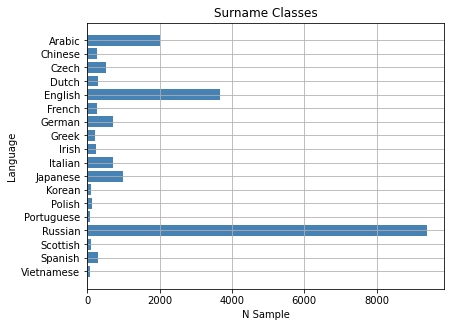

In [10]:
from os import listdir, path

langs, langs_n = [], []
for fn in sorted([_ for _ in listdir(PATH_DATA) if _.endswith('.txt')]):
    langs +=  [path.splitext(path.basename(fn))[0]]

    with open(path.join(PATH_DATA, fn), 'r', encoding="utf8") as fin:
        langs_n += [len(fin.read().splitlines())]

# plot
plt.barh(langs[::-1], langs_n[::-1], color='steelblue')
plt.xlabel('N Sample'); plt.ylabel('Language'); plt.title('Surname Classes')
plt.grid(True)
plt.show()

In [11]:
from os import listdir, path

# Letter index 0 is the padding value, i.e. padding to fill up the vector to SEQ_SIZE, necessary for batched
# Note that eventually we will use torch Tensor to represent these fixed length sequences
LetterVocabulary, LetterVocabularyIndex, Index2Voc, Sequences = {' ':0}, 1, {0:' '}, {}
for fn in sorted([_ for _ in listdir(PATH_DATA) if _.endswith('.txt')]):
    lang, seqs = path.splitext(path.basename(fn))[0], []

    if lang not in LANGS:  # test case
        continue

    with open(path.join(PATH_DATA, fn), 'r', encoding="utf8") as fin:
        for row in fin.read().splitlines():
            seq = np.zeros(SEQ_SIZE, dtype=np.int32)
            for i_, letter in enumerate(row.lower()):  # Convert the surname to lower case
#            for i_, letter in enumerate(row):
                if i_ < SEQ_SIZE:
                    if letter not in LetterVocabulary:
                        LetterVocabulary[letter] = LetterVocabularyIndex
                        Index2Voc[LetterVocabularyIndex] = letter
                        LetterVocabularyIndex += 1
                    seq[i_] = LetterVocabulary[letter]
            seqs += [seq]
    Sequences[lang] = seqs

# Sanity check
def print_names(_lang, _k):
    print(''.join([Index2Voc[c] for c in Sequences[_lang][_k]]), Sequences[_lang][_k]) if _lang in LANGS else None

# Some examples
print_names('English', 35)
print_names('Vietnamese', 3)
print_names('Irish', 3)
print_names('Arabic', 1923)
print_names('Czech', 160)
print_names('Chinese', 233)
print_names('German', 1)
print_names('Korean', 69)
print_names('Portuguese', 4)
print_names('Russian', 1678)

ainley               [ 8 14  7 16 11  6  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
pham                 [25  2  8 15  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
aodha                [ 8  3 10  2  8  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
maalouf              [15  8  8 16  3  4 17  0  0  0  0  0  0  0  0  0  0  0  0  0]
jarzembowski         [21  8  5 13 11 15 18  3 20  9  1 14  0  0  0  0  0  0  0  0]
lu:                  [16  4 27  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
abel                 [ 8 18 11 16  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
si                   [ 9 14  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
araújo               [ 8  5  8 39 21  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
bekovich-cherkassky  [18 11  1  3 28 14 22  2 24 22  2 11  5  1  8  9  9  1  6  0]


In [12]:
# Sanity
N = sum([len(Sequences[_]) for _ in Sequences])

T = Sequences['English'][0].shape[0]

C = len(np.unique(Sequences.keys())[0])

print(N, T, C)

20074 20 18


In [13]:
import itertools

# Pool all sequences and all languages
Seqs = [Sequences[LANGS[_]] for _ in range(C)]
Seqs = list(itertools.chain(*Seqs))

# Number of features is the number of unique characters
M = np.max(Seqs)  # Max sequence length
print(f'M= {M}')

M= 57


In [14]:
# Apriori class balance, i.e. inverse probability of the class
nk = np.array([len(Sequences[LANGS[_]]) for _ in range(C)], dtype=np.float32)
nk = (N/nk)
nk = nk/nk.sum()

# Class weights, inverse apriori probability
WEIGHTS = torch.tensor(nk, dtype=torch.float32)

print(WEIGHTS)

tensor([0.0032, 0.0059, 0.0439, 0.0227, 0.0396, 0.0425, 0.0163, 0.0580, 0.0507,
        0.0166, 0.0119, 0.1252, 0.0847, 0.1591, 0.0013, 0.1177, 0.0395, 0.1613])


In [15]:
# Ground truth
y = [[_]*len(Sequences[LANGS[_]]) for _ in range(C)]
y = np.array(list(itertools.chain(*y)))

In [16]:
# One-hot encode every position of the sequence
X = np.empty((N,M))
n = 0
for lang in Sequences.keys():
    for seq in Sequences[lang]:
        sxx = np.zeros((M,), dtype=np.float32)
        for i_ in range(SEQ_SIZE):  # for the duration of the signal
            if seq[i_] > 0:
                sxx[seq[i_]-1] = 1
        X[n] = sxx
        n += 1

In [17]:
%%time

# Borrowed from previous lectures
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

def kfold_eval_docs(_clf, _X, _y):
    # Need indexable data structure
    acc = []
    kf = StratifiedKFold(n_splits=10, shuffle=False, random_state=None)
    for train_index, test_index in kf.split(_X, _y):
        _clf.fit(_X[train_index], _y[train_index])
        y_pred = _clf.predict(_X[test_index])
        acc += [accuracy_score(_y[test_index], y_pred)]
    return np.array(acc)

nb = GaussianNB()
acc = kfold_eval_docs(nb, X, y)
print(f'Naive Bayes CV accuracy= {np.mean(acc):.3f} {chr(177)}{np.std(acc):.3f}')

rf = RandomForestClassifier(n_jobs=4, n_estimators=300, max_depth=10, random_state=None, class_weight='balanced')
acc = kfold_eval_docs(rf, X, y)
print(f'Random Forest CV accuracy= {np.mean(acc):.3f} {chr(177)}{np.std(acc):.3f}')

svm = SVC(kernel='rbf', gamma='scale', class_weight='balanced')
acc = kfold_eval_docs(svm, StandardScaler().fit_transform(X), y)
print(f'Support Vector Machine CV accuracy= {np.mean(acc):.3f} {chr(177)}{np.std(acc):.3f}')

Naive Bayes CV accuracy= 0.060 ±0.036
Random Forest CV accuracy= 0.462 ±0.038
Support Vector Machine CV accuracy= 0.418 ±0.040
CPU times: user 8min 33s, sys: 11 s, total: 8min 44s
Wall time: 8min 24s


#RNN Cassifier

In [18]:
# One-hot encode every position of the sequence
# List of sequence, language tuples for easy shuffling
def get_Xy():
    Xy = []
    for lang in Sequences.keys():
        for seq in Sequences[lang]:
            T = SEQ_SIZE  # necessary for batched
            sxx = np.zeros((T, M))
            for i in range(T):  # for the duration of the signal
                if seq[i] > 0:
                    sxx[i, seq[i]-1] = 1
            Xy += [(torch.tensor(sxx, dtype=torch.float32),
                    torch.tensor([LANGS_CAT[lang]], dtype=torch.int64))]
    return Xy

# Helper functions
def get_X(_Xy):
    return [_[0] for _ in _Xy]

def get_y(_Xy):
    return [int(_[1].data[0]) for _ in _Xy]

# Sanity
Xy = get_Xy()
print(len(Xy))

# printing the confusion matrix below
def get_cm(_y, _p):
    from sklearn.metrics import confusion_matrix
    import pandas as pd

    cm = confusion_matrix(_y, _p, labels=list(range(len(LANGS))))
    display(pd.DataFrame(cm, index=[_[:5] for _ in LANGS], columns=[_[:5] for _ in LANGS]))

20074


In [19]:
class My_RNN(nn.Module):

    def __init__(self, n_hidden, n_hid_layers=1, epochs=10, eta=0.0005, batch_size=100, weight=None, info=True):
        """ A PyTorch neural network model based on RNN cell, batched """
        super(My_RNN, self).__init__()

        self.n_hidden= n_hidden  # hidden layer size
        self.n_hid_layers= n_hid_layers  # number of hidden layers
        self.epochs= epochs  # number of learning iterations
        self.eta= eta  # learning rate
        self.B= batch_size  # size of training batch - 1 would not work
        self.info= info  # debug info

        self.rnn, self.outlayer = None, None

        self.softmax = nn.LogSoftmax(dim=1)
        # loss function, since the last layer is nn.LogSoftmax
        self.criterion = nn.NLLLoss(weight=weight)

    def forward(self, _X, _h0):
        output, hn = self.rnn(_X, _h0)
        output = self.outlayer(output[:, -1, :])  # output is batched
        output = self.softmax(output)
        return output, hn

    def init_cell(self, _M):  # Create variations of our RNN by overriding init_cell
        dropout = 0.2 if self.n_hid_layers > 1 else 0
        return nn.RNN(_M, self.n_hidden, self.n_hid_layers,
                      nonlinearity='relu',
                      bias=False, batch_first=True, dropout=dropout)

    def init_hidden(self, _B):  # batch_first = True
        return torch.zeros(self.n_hid_layers, _B, self.n_hidden).to(Gpu)  # Extra dimension - batch

    def fit(self, _Xy):
        from random import shuffle
        import sys
        import torch.optim as optim

        M= _Xy[0][0].shape[1]  # number of features, based on batch input
        C= np.unique([int(_[1].data[0]) for _ in _Xy]).shape[0]  # number of class labels

        self.rnn = self.init_cell(M).to(Gpu)
        self.outlayer = nn.Linear(self.n_hidden, C).to(Gpu)

        self.optimizer = optim.Adam(self.parameters(), lr=self.eta)

        for e in range(self.epochs):
            # Shuffle the input to randomly interleave classes, note that they are tuples, i.e. (x, y)
            shuffle(_Xy)

            N = len(_Xy)
            L, totloss = 0, 0

            while L < N-self.B:
                sxx = torch.stack([_[0] for _ in _Xy[L:L+self.B]]).to(Gpu)
                y = torch.tensor([_[1] for _ in _Xy[L:L+self.B]], dtype=torch.int64).to(Gpu)
                output, loss = self.train_signal(sxx, y, self.B)

                totloss += loss
                L += self.B

                if self.info:
                    sys.stderr.write(f"\r{e+1:03d}/{self.epochs:4d} | Loss: {loss:6.2f} | "
                                     f"Avg loss: {totloss/(e+1):6.2f} | {y.data.tolist()[0]}")
                    sys.stderr.flush()

    def train_signal(self, _sxx, _y, _B):
        h0 = self.init_hidden(_B)
        self.optimizer.zero_grad()

        output, hn = self.forward(_sxx, h0)

        loss = self.criterion(output, _y)
        loss.backward()
        self.optimizer.step()
        return output, loss.item()

    def predict(self, _sxx):  # Tensor dimensions: B x T x M
        _sxx = torch.stack(_sxx)
        with torch.no_grad():
            h0 = self.init_hidden(_sxx.shape[0])  # reset the hidden layer
            output, hn = self.forward(_sxx.to(Gpu), h0)

        p_values, indices = output.max(dim=1)
        return indices.to('cpu')


# Info about the RNN
print(My_RNN(10, n_hid_layers=1, eta=0.001))

My_RNN(
  (softmax): LogSoftmax(dim=1)
  (criterion): NLLLoss()
)


In [20]:
%%time

Xy = get_Xy()

Acc = []
for _ in range(1):  # Statistical variation

    rnn = My_RNN(128, n_hid_layers=2, epochs=1000, eta=0.005, batch_size=2000, weight=WEIGHTS, info=True).to(Gpu)
    rnn.fit(Xy)

    y_pred = rnn.predict(get_X(Xy))
    Acc += [np.sum(np.array(y_pred) == np.array(get_y(Xy)))/len(y_pred)]

print(f'RNN reclassification Acc= {np.mean(Acc):.2f} {chr(177)}{np.std(Acc):.3f}')

1000/1000 | Loss:   0.56 | Avg loss:   0.00 | 0

RNN reclassification Acc= 0.75 ±0.000
CPU times: user 7min 2s, sys: 4.27 s, total: 7min 6s
Wall time: 2min 47s


In [21]:
get_cm(get_y(Xy), y_pred)

,Engli,Arabi,Chine,Czech,Dutch,Frenc,Germa,Greek,Irish,Itali,Japan,Korea,Polis,Portu,Russi,Scott,Spani,Vietn
Engli,1795,27,38,131,105,269,496,7,331,49,17,7,6,28,37,270,46,9
Arabi,0,1938,1,1,0,0,0,0,0,5,53,0,1,0,0,0,1,0
Chine,0,0,237,0,0,0,0,0,0,0,1,15,0,0,0,0,0,15
Czech,25,0,1,378,2,3,81,0,4,6,3,0,9,0,1,3,3,0
Dutch,1,0,3,0,272,10,8,0,0,2,0,0,0,0,0,0,0,1
Frenc,21,0,2,1,0,249,1,0,1,0,0,0,0,0,0,0,1,1
Germa,61,1,5,6,64,32,540,0,0,6,1,0,1,0,0,0,3,4
Greek,0,1,0,0,0,1,0,196,0,2,0,0,1,2,0,0,0,0
Irish,8,0,0,0,0,1,0,0,216,0,0,0,0,0,0,7,0,0
Itali,7,1,4,6,1,6,0,1,0,615,7,0,2,13,0,0,46,0


In [22]:
%%time

Xy = get_Xy()

cm_y, cm_p = [], []

Acc = []
kf = StratifiedKFold(n_splits=10)
for tr_ix, ts_ix in kf.split(np.arange(len(Xy)), get_y(Xy)):
    rnn = My_RNN(128, n_hid_layers=2, epochs=1000, eta=0.005, batch_size=2000, weight=WEIGHTS, info=True).to(Gpu)

    X_tr = [Xy[_] for _ in tr_ix]  # predict uses X and y as a tuple
    X_ts = get_X([Xy[_] for _ in ts_ix])
    y_ts = get_y([Xy[_] for _ in ts_ix])

    rnn.fit(X_tr)
    y_pred = rnn.predict(X_ts)

    Acc += [np.sum(np.array(y_pred) == np.array(y_ts))/len(y_pred)]

    cm_y += y_ts
    cm_p += y_pred.tolist()

print(f'RNN 10-fold CV Acc= {np.mean(Acc):.2f} {chr(177)}{np.std(Acc):.3f}')

1000/1000 | Loss:   1.41 | Avg loss:   0.01 | 14

RNN 10-fold CV Acc= 0.57 ±0.056
CPU times: user 1h 1min 12s, sys: 24.5 s, total: 1h 1min 36s
Wall time: 22min 4s


# LSTM classifier

In [23]:
class My_LSTM(My_RNN):

    def __init__(self, n_hidden, n_hid_layers=1, epochs=10, eta=0.0005, batch_size=100, weight=None, info=True):
        """ A PyTorch neural network model based on LSTM RNN cell, batched """
        super(My_LSTM, self).__init__(n_hidden, n_hid_layers=n_hid_layers,
                                      epochs=epochs, eta=eta, batch_size=batch_size, weight=weight, info=info)

    def init_hidden(self, _B):  # batch_first = True
        return (torch.zeros(self.n_hid_layers, _B, self.n_hidden).to(Gpu),
                torch.zeros(self.n_hid_layers, _B, self.n_hidden).to(Gpu))

    def init_cell(self, _M):  # override
        dropout = 0.2 if self.n_hid_layers > 1 else 0
        return nn.LSTM(_M, self.n_hidden, self.n_hid_layers,
                       #nonlinearity='relu',
                       bias=False, batch_first=True, dropout=dropout)

# Info about the RNN
print(My_LSTM(10, n_hid_layers=1, eta=0.001))

My_LSTM(
  (softmax): LogSoftmax(dim=1)
  (criterion): NLLLoss()
)


In [24]:
%%time

Xy = get_Xy()

Acc = []
for _ in range(1):  # Statistical variation

    rnn = My_LSTM(128, n_hid_layers=1, epochs=1000, eta=0.005, batch_size=2000, weight=WEIGHTS, info=True).to(Gpu)
    rnn.fit(Xy)

    y_pred = rnn.predict(get_X(Xy))
    Acc += [np.sum(np.array(y_pred) == np.array(get_y(Xy)))/len(y_pred)]

print(f'RNN reclassification Acc= {np.mean(Acc):.2f} {chr(177)}{np.std(Acc):.3f}')

1000/1000 | Loss:   0.09 | Avg loss:   0.00 | 5

RNN reclassification Acc= 0.97 ±0.000
CPU times: user 7min 21s, sys: 3.03 s, total: 7min 24s
Wall time: 2min 43s


In [25]:
get_cm(get_y(Xy), y_pred)

,Engli,Arabi,Chine,Czech,Dutch,Frenc,Germa,Greek,Irish,Itali,Japan,Korea,Polis,Portu,Russi,Scott,Spani,Vietn
Engli,3376,3,8,7,11,43,28,1,55,2,0,6,4,12,2,99,9,2
Arabi,0,2000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Chine,0,0,240,0,0,1,0,0,0,0,0,18,0,0,0,1,0,8
Czech,0,0,0,508,2,1,0,0,0,0,0,0,5,0,0,3,0,0
Dutch,0,0,2,0,290,3,0,0,0,0,0,0,1,0,0,0,1,0
Frenc,0,0,0,0,2,263,0,0,2,0,0,0,5,0,0,1,4,0
Germa,0,1,1,12,25,12,659,0,3,0,0,2,4,0,0,1,3,1
Greek,0,0,0,0,0,0,0,203,0,0,0,0,0,0,0,0,0,0
Irish,0,0,0,0,0,1,0,0,225,0,0,0,0,0,0,6,0,0
Itali,0,0,1,0,2,1,0,0,0,672,0,0,2,9,0,0,22,0


In [26]:
''' This code takes forever . Hence commneted out
%%time

Xy = get_Xy()

cm_y, cm_p = [], []

Acc = []
kf = StratifiedKFold(n_splits=10)
for tr_ix, ts_ix in kf.split(np.arange(len(Xy)), get_y(Xy)):
    rnn = My_LSTM(128, n_hid_layers=1, epochs=1000, eta=0.005, batch_size=2000, weight=WEIGHTS, info=True).to(Gpu)

    X_tr = [Xy[_] for _ in tr_ix]  # predict uses X and y as a tuple
    X_ts = get_X([Xy[_] for _ in ts_ix])
    y_ts = get_y([Xy[_] for _ in ts_ix])

    rnn.fit(X_tr)
    y_pred = rnn.predict(X_ts)

    Acc += [np.sum(np.array(y_pred) == np.array(y_ts))/len(y_pred)]

    cm_y += y_ts
    cm_p += y_pred.tolist()

print(f'RNN 10-fold CV Acc= {np.mean(Acc):.2f} {chr(177)}{np.std(Acc):.3f}')
...

527/1000 | Loss:   0.10 | Avg loss:   0.00 | 0

KeyboardInterrupt: ignored

In [27]:
get_cm(cm_y, cm_p)

,Engli,Arabi,Chine,Czech,Dutch,Frenc,Germa,Greek,Irish,Itali,Japan,Korea,Polis,Portu,Russi,Scott,Spani,Vietn
Engli,1737,32,32,118,81,101,169,13,104,40,18,13,12,8,241,180,25,10
Arabi,0,1600,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Chine,21,2,99,3,1,4,4,0,0,1,4,31,1,0,16,4,0,25
Czech,79,7,1,76,7,5,34,4,3,17,14,1,15,2,136,4,8,2
Dutch,81,4,5,7,46,11,45,0,3,4,3,0,4,0,21,0,3,0
Frenc,88,3,1,7,8,40,16,3,6,8,0,2,4,1,23,2,9,1
Germa,142,5,5,43,64,18,168,2,4,3,2,3,5,1,99,9,2,4
Greek,13,2,0,3,1,2,0,110,0,7,3,0,3,2,12,2,3,0
Irish,83,2,0,1,0,0,6,0,69,2,0,0,0,1,15,7,0,0
Itali,44,10,2,9,3,7,5,11,2,300,36,0,3,19,66,0,49,1



Exercise 2. Modify the ingest-script to have the first letters as capitalized letters and re-run the regular classifiers.

[20 pts]
1. List three popular RNN types, then briefly compare and contrast their features and
applications.



2. [20 pts]
Explain why the LSTM RNN performed superbly compared to the other classifiers in the module including the regular classifiers.

Ans -
Memory Cells: LSTM units have a unique design that includes memory cells, gates (input, forget, and output gates), and a hidden state. This design allows LSTMs to store and recall information over long sequences, making them particularly effective for tasks that involve sequential data, like surnames in different languages.

Handling Long-Term Dependencies: One of the main challenges with basic RNNs is the vanishing gradient problem, which makes it difficult for the RNN to learn and remember information from earlier time steps in long sequences. LSTMs are specifically designed to address this issue, allowing them to capture long-term dependencies in the data.

Gating Mechanisms: The gates in the LSTM units decide what information to store, discard, or output at each time step. This selective ability helps LSTMs manage and prioritize the information flow, making them more effective in understanding the structure and patterns in sequential data.

Regularization: The dropout mechanism, which can be applied between LSTM layers, helps prevent overfitting, especially when dealing with a large number of parameters.

Batch Training: The code uses batch training, which can help in stabilizing the learning process and speeding up convergence. LSTMs can benefit from this, especially when trained on large datasets.

Class Imbalance Handling: The code uses class weights (WEIGHTS) to handle class imbalance. This ensures that minority classes are given more importance during training, which can improve the overall classification performance.

Flexibility: Neural networks, including LSTMs, have the ability to learn complex non-linear relationships. This flexibility can allow them to outperform traditional classifiers, especially when there's enough data to train on.

Optimization: The use of the Adam optimizer, which adjusts the learning rate during training, can help in faster and more stable convergence.

Data Representation: One-hot encoding of the sequences ensures that the input data is in a format that's suitable for neural network training. This representation can capture the nuances in the data better than some traditional feature extraction methods.

3. [20 pts]
Build a classifier using only two languages {English and Scottish} from the surname dataset
to distinguish between them. Report 10-fold cross validation performance.


In [31]:
def get_Xy():
    Xy = []
    for lang in LANGS:  # Only process the languages in LANGS
        for seq in Sequences[lang]:
            T = SEQ_SIZE  # necessary for batched
            sxx = np.zeros((T, M))
            for i in range(T):  # for the duration of the signal
                if seq[i] > 0:
                    sxx[i, seq[i]-1] = 1
            Xy += [(torch.tensor(sxx, dtype=torch.float32),
                    torch.tensor([LANGS_CAT[lang]], dtype=torch.int64))]
    return Xy


In [33]:
# Apriori class balance, i.e. inverse probability of the class for only English and Scottish
nk = np.array([len(Sequences['English']), len(Sequences['Scottish'])], dtype=np.float32)
N = sum(nk)
nk = (N/nk)
nk = nk/nk.sum()

# Class weights, inverse apriori probability for only English and Scottish
WEIGHTS = torch.tensor(nk, dtype=torch.float32)


In [34]:
from sklearn.model_selection import StratifiedKFold

import os

# Only consider English and Scottish surnames
LANGS = ('English', 'Scottish')
LANGS_CAT = dict(zip(LANGS, range(len(LANGS))))


def load_surnames_from_file(filepath):
    with open(filepath, 'r', encoding="utf8") as f:
        return f.read().splitlines()

# Assuming the dataset is in a folder named 'surnames'
english_surnames = load_surnames_from_file(PATH_DATA + 'English.txt')
scottish_surnames = load_surnames_from_file(PATH_DATA  + 'Scottish.txt')

# Label the data: 0 for English, 1 for Scottish
data = [(name, 0) for name in english_surnames] + [(name, 1) for name in scottish_surnames]


#Feature Extraction
from sklearn.feature_extraction.text import TfidfVectorizer

names, labels = zip(*data)
vectorizer = TfidfVectorizer(analyzer='char', ngram_range=(1,3))
X = vectorizer.fit_transform(names)
y = labels


#training
Xy = get_Xy()

cm_y, cm_p = [], []
Acc = []

kf = StratifiedKFold(n_splits=10)
for tr_ix, ts_ix in kf.split(np.arange(len(Xy)), get_y(Xy)):
    rnn = My_LSTM(128, n_hid_layers=1, epochs=1000, eta=0.005, batch_size=2000, weight=WEIGHTS, info=True).to(Gpu)

    X_tr = [Xy[_] for _ in tr_ix]  # predict uses X and y as a tuple
    X_ts = get_X([Xy[_] for _ in ts_ix])
    y_ts = get_y([Xy[_] for _ in ts_ix])

    rnn.fit(X_tr)
    y_pred = rnn.predict(X_ts)

    Acc += [np.sum(np.array(y_pred) == np.array(y_ts))/len(y_pred)]
    cm_y += y_ts
    cm_p += y_pred.tolist()

print(f'LSTM 10-fold CV Acc= {np.mean(Acc):.2f} ± {np.std(Acc):.3f}')


1000/1000 | Loss:   0.10 | Avg loss:   0.00 | 0

LSTM 10-fold CV Acc= 0.67 ± 0.179


4. [40 pts]
Determine an optimum sequence length (i.e., surname length), by finding a sweet spot
between the run-time (due to the sequence length) and the classification performance.

In [35]:
import os
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import time
from sklearn.model_selection import StratifiedKFold

# Load surnames from file
def load_surnames_from_file(filepath):
    with open(filepath, 'r', encoding="utf8") as f:
        return f.read().splitlines()

# Only consider English and Scottish surnames
LANGS = ('English', 'Scottish')
LANGS_CAT = dict(zip(LANGS, range(len(LANGS))))

# Assuming the dataset is in a folder named 'surnames'
english_surnames = load_surnames_from_file(PATH_DATA + 'English.txt')
scottish_surnames = load_surnames_from_file(PATH_DATA  + 'Scottish.txt')


# Combine and label the data
data = [(name, 0) for name in english_surnames] + [(name, 1) for name in scottish_surnames]
names, labels = zip(*data)

# Analyze the distribution of surname lengths
surname_lengths = [len(name) for name in names]
plt.hist(surname_lengths, bins=50)
plt.xlabel('Surname Length')
plt.ylabel('Frequency')
plt.title('Distribution of Surname Lengths')
plt.show()

# Your existing LSTM model and data preprocessing functions go here
# ... (e.g., My_LSTM, get_Xy, etc.)

# Experiment with different sequence lengths
sequence_lengths = list(range(5, max(surname_lengths), 5))
performances = []
runtimes = []

for seq_len in sequence_lengths:
    SEQ_SIZE = seq_len  # Adjust the sequence size

    # Data preprocessing (adjust for the new sequence length)
    # ... (as in the previous code)

    # Train the LSTM model
    start_time = time.time()

    Xy = get_Xy()
    rnn = My_LSTM(128, n_hid_layers=1, epochs=1000, eta=0.005, batch_size=2000, weight=WEIGHTS, info=False).to(Gpu)
    rnn.fit(Xy)

    y_pred = rnn.predict(get_X(Xy))
    acc = np.sum(np.array(y_pred) == np.array(get_y(Xy)))/len(y_pred)

    end_time = time.time()

    # Record performance and runtime
    performances.append(acc)
    runtimes.append(end_time - start_time)

# Plot runtime and performance against sequence lengths
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(sequence_lengths, runtimes, '-o')
plt.xlabel('Sequence Length')
plt.ylabel('Runtime (seconds)')
plt.title('Runtime vs. Sequence Length')

plt.subplot(1, 2, 2)
plt.plot(sequence_lengths, performances, '-o')
plt.xlabel('Sequence Length')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Sequence Length')

plt.tight_layout()
plt.show()



FileNotFoundError: ignored